In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel, BertTokenizer, BertModel

2022-10-27 13:56:06.212648: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-27 13:56:06.212780: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load in the Data

train = pd.read_csv('../input/contradictory-my-dear-watson/train.csv')
test = pd.read_csv('../input/contradictory-my-dear-watson/test.csv')

In [4]:
# HuggingFace nlp package that has among others further data that we can train on as many entries in this challenge already did

! pip install nlp
from nlp import load_dataset

     |████████████████████████████████| 1.7 MB 2.1 MB/s eta 0:00:01


In [5]:
# Load the 'MNLI' dataset

def load_mnli(use_validation=True):
    """
    Function that loads in the multilingual nli dataset
    """
    res = []
    dataset = load_dataset('multi_nli')
    key = ['train', 'validation_matched', 'validation_mismatched'] if use_validation else ['train']
    
    for k in key:
        for record in dataset[k]:
        
            x1, x2, x3 = record['premise'], record['hypothesis'], record['label']
        
            if x1 and x2 and x3 in {0,1,2}:
                res.append((x1,x2,x3, 'en'))
            
    res = pd.DataFrame(res, columns=['premise', 'hypothesis', 'label', 'lang_abv'])
    
    return res

In [6]:
mnli = load_mnli()

Downloading:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/227M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/plain_text/1.0.0/60774175381b9f3f1e6ae1028229e3cdb270d50379f45b9f2c01008f50f09e6b. Subsequent calls will reuse this data.


In [7]:
mnli.head()

,premise,hypothesis,label,lang_abv
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,en
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,en
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,en
3,How do you know? All this is their information...,This information belongs to them.,0,en
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,en


In [8]:
X = train[['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label']]

In [9]:
mnli = mnli[['premise', 'hypothesis', 'lang_abv', 'label']]
mnli.insert(0, 'language', 'English')
mnli = mnli[['premise', 'hypothesis', 'lang_abv', 'language', 'label']]
mnli.insert(0, 'id', 'xxx')

In [10]:
X = pd.concat([X, mnli], axis=0)

In [11]:
tokenizer = AutoTokenizer.from_pretrained('joeddav/xlm-roberta-large-xnli')

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

In [12]:
def encode_sentence(s):
    """
    Helper Function for tokenizing sentences
    """
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')   # add the seperator token to the end of each sentence
    return tokenizer.convert_tokens_to_ids(tokens)

In [13]:
def bert_encode(hypotheses, premises, tokenizer):
    """
    This function prepares the inputs for the bert model and its expected inputs
    """
    
    num_examples = len(hypotheses)
    
    sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])   # tokenizes the hypothesis
    
    sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])     # tokenizes the premises
    
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]   # Adds the CLS token such that the model understands its task
    
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)    # concatenates both sentences with the CLS token as one input line
    
    input_mask = tf.ones_like(input_word_ids).to_tensor()     # creates the input mask
    
    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.zeros_like(sentence2)
    
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()
    
    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask
    }
    
    
    return inputs
    

In [14]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

2022-10-27 13:57:14.320271: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-27 13:57:14.323415: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-27 13:57:14.323456: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-27 13:57:14.323485: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ab41867b1143): /proc/driver/nvidia/version does not exist
2022-10-27 13:57:14.326032: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [15]:
X_input = bert_encode(X.premise.values, X.hypothesis.values, tokenizer)

In [16]:
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [17]:
max_len = 128

def build_model():
    
    encoder = TFAutoModel.from_pretrained('joeddav/xlm-roberta-large-xnli')
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name='input_mask')
    
    embedding= encoder([input_word_ids, input_mask])[0]
    
    output= tf.keras.layers.Dense(3, activation='softmax')(embedding[:, 0, :])
    
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [18]:
try:
    
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy(tpu) 
except ValueError: 
    strategy = tf.distribute.get_strategy() 
    
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,)
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() 
else:
    strategy = tf.distribute.get_strategy() 

2022-10-27 14:01:16.213166: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-27 14:01:16.238561: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-10-27 14:01:16.238664: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-10-27 14:01:16.258390: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-10-27 14:01:16.258448: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2022-10-27 14:01:16.259190: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30020


Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

2022-10-27 14:04:02.102876: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.
2022-10-27 14:04:05.844489: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.
2022-10-27 14:04:08.637925: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.
2022-10-27 14:04:11.284707: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.
2022-10-27 14:04:13.391996: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024008192 exceeds 10% of free system memory.
Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. i

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 1024)         0           tfxlm_roberta_model[0][0]    

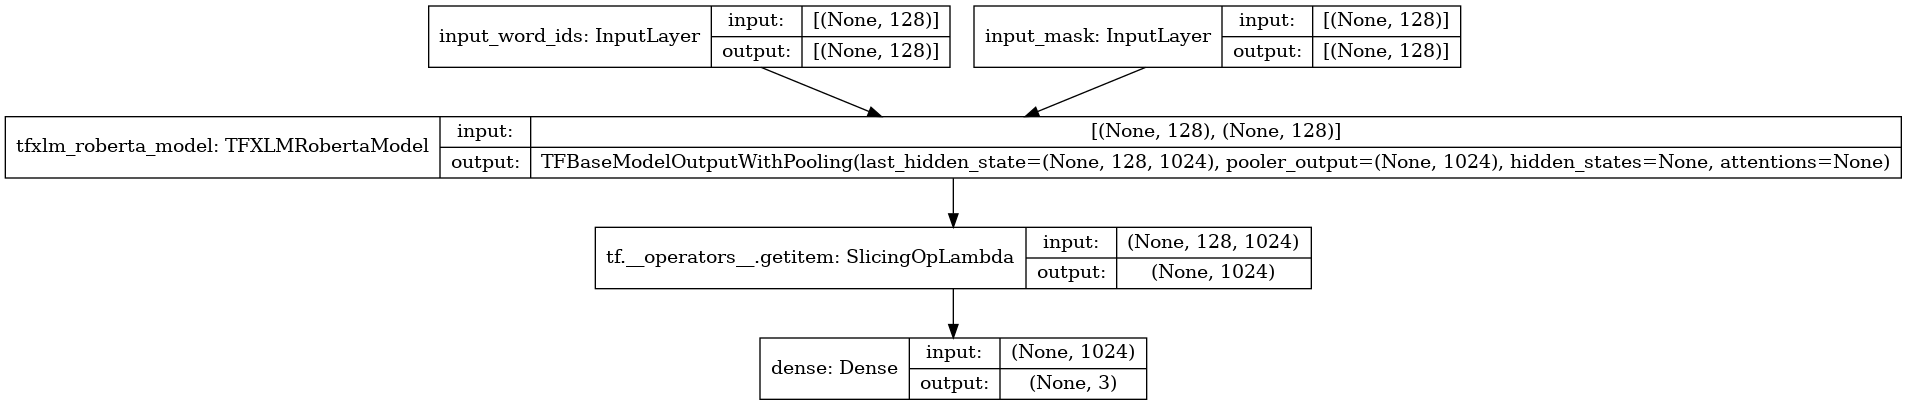

In [19]:
with strategy.scope():
    model = build_model()
    model.summary()
    
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [20]:
model.layers[2].trainable=True

In [21]:
for key in train_input.keys():
    train_input[key] = train_input[key][:, :max_len]

In [22]:
for key in X_input.keys():
    X_input[key] = X_input[key][:, :max_len]

In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

model.fit(X_input, X.label.values, epochs=5, verbose=1, validation_split = 0.01, batch_size = 16*strategy.num_replicas_in_sync, callbacks=[early_stop])

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


3283/3283 [==============================] - 944s 254ms/step - loss: 0.2419 - accuracy: 0.9148 - val_loss: 0.3601 - val_accuracy: 0.8820
Epoch 2/5
3283/3283 [==============================] - 811s 247ms/step - loss: 0.1775 - accuracy: 0.9374 - val_loss: 0.3845 - val_accuracy: 0.8874
Epoch 3/5
3283/3283 [==============================] - 812s 247ms/step - loss: 0.1364 - accuracy: 0.9527 - val_loss: 0.4178 - val_accuracy: 0.8843
Epoch 4/5
3283/3283 [==============================] - 812s 247ms/step - loss: 0.1068 - accuracy: 0.9633 - val_loss: 0.4820 - val_accuracy: 0.8792


In [24]:
for key in test_input.keys():
    test_input[key] = test_input[key][:, :max_len]

In [25]:
pred = [np.argmax(i) for i in model.predict(test_input)]

In [26]:
submission = test.id.copy().to_frame()
submission['prediction'] = pred

In [27]:
submission.to_csv("submission.csv", index = False)